In [34]:
import numpy as np
import pandas as pd
from qiskit import Aer, execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit import Aer, execute
from scipy.stats import entropy

In [35]:
# def preprocess_data(filepath):
#     # Load data
#     data = pd.read_csv(filepath, sep='\t', index_col=0)
#     # Binarize data
#     binarized_data = (data > 0).astype(int)
#     # Compute activation ratios
#     activation_ratios = binarized_data.mean(axis=1).values
#     # Compute observed distribution p_obs
#     # Here, we assume each unique combination of gene expressions in cells as a different state
#     labels = binarized_data.apply(lambda row: ''.join(row.astype(str)), axis=0)
#     p_obs = labels.value_counts(normalize=True).reindex([format(i, f'0{len(activation_ratios)}b') for i in range(2**len(activation_ratios))], fill_value=0).values
#     return activation_ratios, p_obs

def preprocess_data(filepath):
    # Load data from the specified file path
    data = pd.read_csv(filepath, sep='\t', index_col=0)
    
    # Binarization: Expression values greater than 0 are set to 1, and 0 otherwise
    binarized_data = (data > 0).astype(int)
    
    # Compute activation ratios: The mean of binarized data across columns (samples) for each gene
    activation_ratios = binarized_data.mean(axis=1).values
    
    # Generate labels for each sample based on the binarized gene expression states
    # Since each column in the binarized matrix represents a sample's gene expression profile,
    # we iterate over columns (axis=0) to concatenate gene states into labels for each sample
    labels = binarized_data.apply(lambda col: ''.join(col.astype(str)), axis=0)
    
    # Compute the observed distribution (p_obs) by counting the frequency of each unique label (sample state)
    p_obs_counts = labels.value_counts(normalize=True)
    p_obs = p_obs_counts.values
    
    return activation_ratios, p_obs

In [36]:
def initialize_theta(n_genes, activation_ratios):
    """Explicit initialization of theta."""
    theta = np.zeros((n_genes, n_genes))
    for k in range(n_genes):
        theta[k, k] = 2 * np.arcsin(np.sqrt(activation_ratios[k]))  # Diagonal initialization
    return theta

In [37]:
def build_qscgrn_circuit(theta):
    n = theta.shape[0]
    qr = QuantumRegister(n)
    cr = ClassicalRegister(n)
    circuit = QuantumCircuit(qr, cr)
    # Apply Ry gates based on activation ratios
    for i in range(n):
        circuit.ry(theta[i, i], qr[i])
    # Apply controlled-RY gates based on theta parameters
    for i in range(n):
        for j in range(i + 1, n):
            circuit.cry(theta[i, j], qr[i], qr[j])
            circuit.cry(theta[j, i], qr[j], qr[i])
    circuit.measure(qr, cr)
    return circuit

In [38]:
def simulate_circuit(circuit):
    backend = Aer.get_backend('qasm_simulator')
    result = execute(circuit, backend, shots=1024).result()
    counts = result.get_counts()
    n_qubits = len(circuit.qubits)
    p_sim = np.zeros(2 ** n_qubits)  # This should match the number of possible states
    for state, count in counts.items():
        state_idx = int(state, 2)  # Convert binary string to integer
        p_sim[state_idx] = count / 1024  # Assign the simulation result
    return p_sim

def compute_kl_divergence(p_obs, p_sim):
    epsilon = 1e-10  # To avoid division by zero
    kl_div = np.sum(np.where(p_obs != 0, p_obs * np.log(p_obs / (p_sim + epsilon)), 0))
    return kl_div

# def compute_kl_divergence(p_obs, p_sim):
#     epsilon = 1e-10  # To avoid division by zero

#     # If p_obs is shorter, append a zero for the missing all-zero state
#     if len(p_obs) < len(p_sim):
#         p_obs = np.append(p_obs, 0)

#     kl_div = np.sum(np.where(p_obs != 0, p_obs * np.log(p_obs / (p_sim + epsilon)), 0))
#     return kl_div

In [39]:
def update_theta(theta, grad, learning_rate):
    """Update theta by subtracting gradient scaled by learning rate."""
    theta_updated = theta - learning_rate * grad
    # Ensure theta remains within bounds [0, π/2] if necessary
    theta_updated = np.clip(theta_updated, 0, np.pi/2)
    return theta_updated

def compute_gradient(theta, activation_ratios, p_obs, epsilon=1e-3):
    """Compute gradient of KL divergence loss with respect to theta."""
    grad = np.zeros_like(theta)
    for i in range(len(theta)):
        for j in range(len(theta)):
            # Perturb theta[i, j] by a small epsilon
            theta_plus = np.copy(theta)
            theta_plus[i, j] += epsilon
            p_sim_plus = simulate_circuit(build_qscgrn_circuit(theta_plus))
            loss_plus = compute_kl_divergence(p_obs, p_sim_plus)

            theta_minus = np.copy(theta)
            theta_minus[i, j] -= epsilon
            p_sim_minus = simulate_circuit(build_qscgrn_circuit(theta_minus))
            loss_minus = compute_kl_divergence(p_obs, p_sim_minus)

            # Approximate gradient using finite differences
            grad[i, j] = (loss_plus - loss_minus) / (2 * epsilon)
    return grad

In [40]:
# def optimize_theta(activation_ratios, p_obs, epochs, learning_rate):
#     n = len(activation_ratios)
#     theta = initialize_theta(n, activation_ratios)
#     for epoch in range(epochs):
#         # Construct the circuit based on the current theta
#         circuit = build_qscgrn_circuit(theta)
#         # Simulate the circuit to get the simulated probability distribution
#         p_sim = simulate_circuit(circuit)
#         # Compute the loss using the KL divergence between observed and simulated distributions
#         loss = compute_kl_divergence(p_obs, p_sim)
        
#         # Compute the gradient of the loss function with respect to theta
#         grad = compute_gradient(theta, activation_ratios, p_obs)
        
#         # Update theta by subtracting the gradient scaled by the learning rate
#         theta = update_theta(theta, grad, learning_rate)
        
#         # Print out the epoch number and current loss for tracking the optimization process
#         print(f'Epoch: {epoch}, Loss: {loss}')
        
#     # After the training (optimization) loop, return the optimized theta
#     return theta

In [41]:
# def plot_histogram(p_obs, p_sim):
#     plt.figure(figsize=(10, 5))
#     plt.bar(range(len(p_obs)), p_obs, width=0.4, label='Observed', alpha=0.6)
#     plt.bar(np.array(range(len(p_sim))) + 0.4, p_sim, width=0.4, label='Simulated', alpha=0.6)
#     plt.ylabel('Probability')
#     plt.title('Comparison of Observed and Simulated Distributions')
#     plt.legend()
#     plt.show()

# def plot_histogram(p_obs, p_sim):
#     # Assuming p_obs and p_sim are already normalized probabilities between 0 and 1
#     # The plotting function will treat these as percentages for display purposes

#     plt.figure(figsize=(10, 5))

#     # Calculate the positions for each bar
#     indices = range(len(p_obs))
#     width = 0.4

#     # Plotting the bars for observed and simulated probabilities
#     plt.bar(indices, p_obs, width, label='Observed', alpha=0.6)
#     plt.bar([i + width for i in indices], p_sim, width, label='Simulated', alpha=0.6)

#     plt.ylabel('Count(%)')
#     plt.title('Comparison of Observed and Simulated Distributions')
    
#     # Adding x-ticks labels if specific state labels are needed
#     # This example uses a simple range but can be replaced with specific state labels if available
#     plt.xticks([i + width / 2 for i in indices], [format(i, '0{}b'.format(int(np.log2(len(p_obs))))) for i in range(len(p_obs))], rotation=90)
    
#     plt.legend()
#     plt.tight_layout()  # Adjust layout to ensure everything fits without overlapping
#     plt.show()


def plot_histogram(p_obs, p_sim):
    # Ensure only non-zero observations are considered
    valid_indices = [i for i, val in enumerate(p_obs) if val > 0.00]
    p_obs_filtered = [p_obs[i] for i in valid_indices]
    p_sim_filtered = [p_sim[i] for i in valid_indices]

    plt.figure(figsize=(10, 5))

    # Calculate positions for each set of bars
    indices = np.arange(len(p_obs_filtered))
    width = 0.4

    # Plot bars for observed and simulated data
    bars_obs = plt.bar(indices, p_obs_filtered, width, label='Observed', alpha=0.6)
    bars_sim = plt.bar(indices + width, p_sim_filtered, width, label='Simulated', alpha=0.6)

    plt.ylabel('Count(%)')
    plt.title('Comparison of Observed and Simulated Distributions')

    # Generate x-ticks for the middle of each group of bars
    plt.xticks(indices + width / 2, [f'{i:0{int(np.log2(len(p_obs)))+1}b}' for i in valid_indices], rotation=90)

    plt.legend()
    plt.tight_layout()

    plt.show()

    
# def plot_histogram(p_obs, p_sim):
#     plt.figure(figsize=(10, 5))
    
#     # Calculate positions for each set of bars
#     indices = np.arange(len(p_obs))
#     width = 0.4

#     # Plot bars for observed and simulated data
#     bars_obs = plt.bar(indices, p_obs, width, label='Observed', alpha=0.6)
#     bars_sim = plt.bar(indices + width, p_sim, width, label='Simulated', alpha=0.6)

#     plt.ylabel('Count(%)')
#     plt.title('Comparison of Observed and Simulated Distributions')

#     # Generate x-ticks for the middle of each group of bars
#     plt.xticks(indices + width / 2, [format(i, '0{}b'.format(int(np.log2(len(p_obs))))) for i in range(len(p_obs))], rotation=90)

#     plt.legend()
#     plt.tight_layout()

#     # Adding text on top of the bars
#     for bars in [bars_obs, bars_sim]:
#         for bar in bars:
#             yval = bar.get_height()
#             plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{yval:.2f}', va='bottom', rotation=90)

#     plt.show()


def plot_adjacency_matrix(theta):
    plt.figure(figsize=(8, 6))
    plt.imshow(theta, cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.title('Gene Regulatory Network (GRN) Adjacency Matrix')
    plt.xlabel('Target Gene')
    plt.ylabel('Regulatory Gene')
    plt.show()

In [42]:
# def smooth_probabilities(probabilities, window_size=5):
#     """Smooth probabilities with a moving average (simple example)."""
#     return np.convolve(probabilities, np.ones(window_size)/window_size, mode='same')

def train_model(filepath, epochs=10, learning_rate=0.001):
    activation_ratios, p_obs = preprocess_data(filepath)
    n_genes = len(activation_ratios)
    theta = initialize_theta(n_genes, activation_ratios)
    for epoch in range(epochs):
        # Compute simulated probabilities
        circuit = build_qscgrn_circuit(theta)
        p_sim = simulate_circuit(circuit)
        # print("p_obs:", p_obs)
        # print("p_sim:", p_sim)

        loss = compute_kl_divergence(p_obs, p_sim)
        
        # Compute gradient and update theta
        grad = compute_gradient(theta, activation_ratios, p_obs)
        theta = update_theta(theta, grad, learning_rate)
        
        print(f'Epoch: {epoch}, Loss: {loss}')
    
    # After training, plot the histogram and adjacency matrix
    p_sim = simulate_circuit(build_qscgrn_circuit(theta))
    plot_histogram(p_obs, p_sim)
    plot_adjacency_matrix(theta)


Epoch: 0, Loss: 0.829471700621093
Epoch: 1, Loss: 0.5306681054607787
Epoch: 2, Loss: 0.4135557002048199
Epoch: 3, Loss: 0.48690939747417905
Epoch: 4, Loss: 0.46483028334765575
Epoch: 5, Loss: 0.47564887175854487
Epoch: 6, Loss: 0.43989139699899804
Epoch: 7, Loss: 0.4381286140791385
Epoch: 8, Loss: 0.33539229512826163
Epoch: 9, Loss: 0.43266412061828896


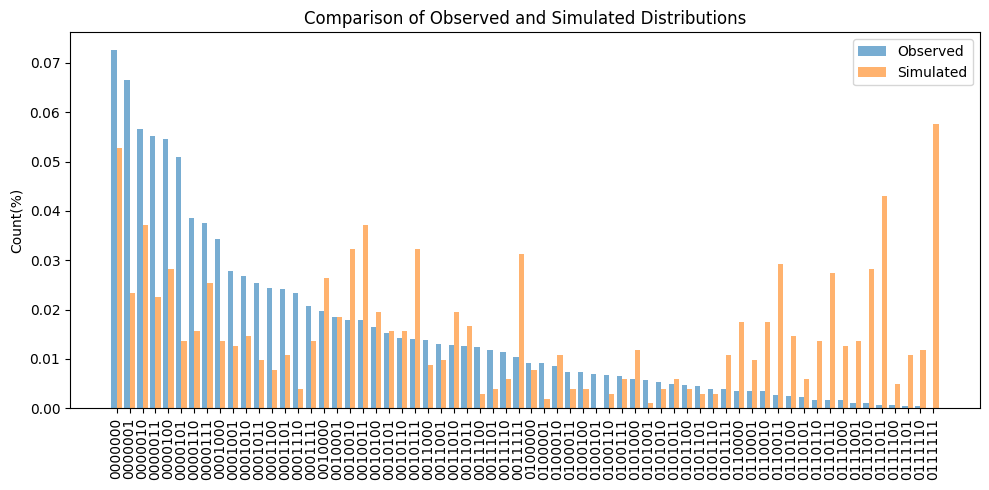

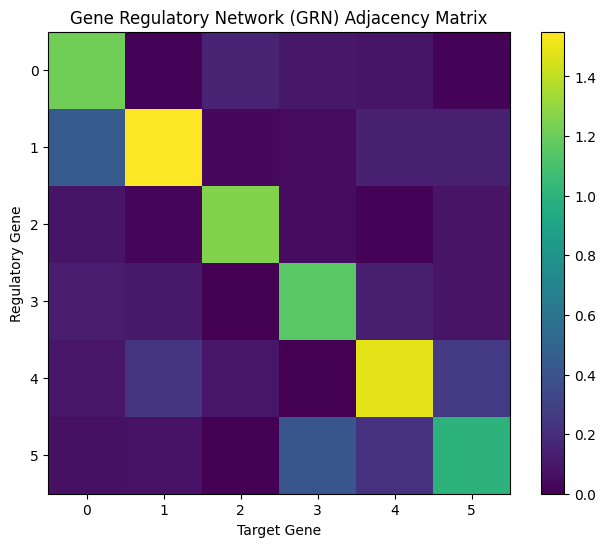

In [43]:
filepath = "/Users/saumyachoudhary/test/dataset/expr_matrix_raw_7.txt"  # Update this to your actual file path
train_model(filepath)